### Semi-Topological Codes
* Construction based off of https://arxiv.org/abs/2005.07016

In [1]:
import networkx as nx
from sage.all import *
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple
import galois
import sympy

In [2]:
def tanner_to_parity_check_mat(G: nx.Graph) -> np.array:
    """
    Converts Tanner graph 'G' into parity check matrix

    Parameters:
    -----------
    G - Tanner graph
    """
    num_var_nodes = 0
    num_check_nodes = 0
    check_node_list = []
    nodes_dict = {}
    G_nodes = list(G.nodes)
    G_edges = list(G.edges)
    for node in G_nodes:
        if (node[0] == 'v'):
            nodes_dict[node] = num_var_nodes
            num_var_nodes += 1
        else:
            nodes_dict[node] = num_check_nodes
            num_check_nodes += 1
    
    mat = np.zeros((num_check_nodes, num_var_nodes))
    for edge in G_edges:
        if (edge[0][0] == 'c'):
            mat[nodes_dict[edge[0]]][nodes_dict[edge[1]]] = 1
        else:
            mat[nodes_dict[edge[1]]][nodes_dict[edge[0]]] = 1
            
    return mat

def parity_check_mat_to_tanner(mat: np.array) -> nx.Graph:
    """ 
    Converts parity check matrix 'mat' into Tanner graph

    Parameters:
    -----------
    mat - parity check matrix
    """
    num_var_nodes = mat.shape[1]
    num_check_nodes = mat.shape[0]
    tan_graph = nx.Graph();
    for i in range(num_var_nodes):
        tan_graph.add_node("v" + str(i))

    for j in range(num_check_nodes):
        tan_graph.add_node("c" + str(j))

    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            if (mat[i][j] == 1):
                tan_graph.add_edge("c" + str(i), "v" + str(j))
    
    return tan_graph

In [3]:
def construct_graph_chain_segment(g: int) -> nx.Graph:
    """ 
    Construct augmentation tanner graph based on 'g' value 

    Parameters:
    -----------
    g - Level of augmentation

    Returns:
    --------
    Augmentation graph to be inserted in parent tanner graph of choice
    """
    aug_graph_pc_mat = np.eye(g)
    for i in range(g - 1):
        aug_graph_pc_mat[i][i + 1] = 1
    #print(aug_graph_pc_mat)
    return parity_check_mat_to_tanner(aug_graph_pc_mat)

def relabel_nodes(chain_seg: nx.Graph, parent_graph: nx.Graph) -> nx.Graph:
    """ 
    Rename nodes of graph chain segment according to where in parent graph it is going to be inserted.

    Parameters:
    -----------
    chain_seg - graph chain segment to be inserted in parent graph
    parent_graph - Parent graph that chain segment is going to be inserted into
    prev_edge - Previous edge that chain segment will replace

    Returns:
    --------
    Graph chain segment with edges and nodes appropriately relabeled.
    """
    parent_node_list = list(parent_graph.nodes)
    node_list = list(chain_seg.nodes)
    next_node_number = np.max([int(node[1:]) for node in parent_node_list]) + 1
    #print(next_node_number)
    curr_node_number = next_node_number
    node_mapping_dict = {}
    count = 0
    while (node_list[count][0] == 'v'):
        node_mapping_dict[node_list[count]] = node_list[count][0] + str(curr_node_number)
        curr_node_number += 1
        count += 1

    curr_node_number = next_node_number 

    while (count < len(node_list) and list(node_list)[count][0] == 'c'):
        node_mapping_dict[node_list[count]] = node_list[count][0] + str(curr_node_number)
        curr_node_number += 1
        count += 1

    relabeled_graph = nx.relabel_nodes(chain_seg, node_mapping_dict, copy=True)

    return relabeled_graph

def node_type_check(node_name: str) -> str:
    """ 
    Finds what type of node (either 'check' or 'var') the given node is based on its name

    Parameters:
    -----------
    node_name - Name of node 

    Returns:
    --------
    Whether it is a check or variable node.
    """
    if (node_name[0] == 'c'):
        return "check"
    return "var"

def get_first_var(graph_chain_seg: nx.Graph):
    """ 
    Get the first variable node (by naming convention)

    Parameters:
    -----------
    graph_chain_seg - Graph chain segment

    Returns:
    --------
    First variable node of graph chain segment
    """
    return list(graph_chain_seg.nodes)[0] 

def get_last_check(graph_chain_seg: nx.Graph):
    """ 
    Get the last variable node (by naming convention)

    Parameters:
    -----------
    graph_chain_seg - Graph chain segment

    Returns:
    --------
    Last check node of graph chain segment
    """
    last_check_pos = len(list(graph_chain_seg.nodes)) - 1
    return list(graph_chain_seg.nodes)[last_check_pos]

def add_graph_chain_seg(parent_graph: nx.Graph, graph_chain_seg: nx.Graph, prev_edge: Tuple) -> nx.Graph:
    """
    Add the graph chain segment to the parent graph 

    Parameters:
    -----------
    parent_graph - The parent graph
    graph_chain_seg - The graph chain segment to be added
    prev_edge - The edge of the parent graph the graph chain segment is replacing

    Returns:
    --------
    The parent graph with its 'prev_edge' replaced by 'graph_chain_seg'
    """ 
    first_var_node = list(graph_chain_seg.nodes)[0]
    #print("The first var node of the graph chain segment is: " + first_var_node)
    last_check_node = list(graph_chain_seg.nodes)[len(list(graph_chain_seg.nodes)) - 1]
    #print("The last check node of the graph chain segment is: " + last_check_node)

    #print("The first edge to add is: " + str((prev_edge[0], last_check_node)))
    parent_graph.add_edge(prev_edge[0], last_check_node)
    #print("The second edge to add is: " + str((first_var_node, prev_edge[1])))
    parent_graph.add_edge(first_var_node, prev_edge[1])

    parent_graph.update(graph_chain_seg.edges)

    return parent_graph

def g_augmented_ldpc_code(parent_graph: nx.Graph, g: int) -> nx.Graph:
    """ 
    Construct edge augmented LDPC code as per https://arxiv.org/abs/2005.07016 Section II

    Parameters:
    -----------
    parent_graph - Parent Graph in the edge augmented LDPC code construction
    g - Augmentation level of edge augmented LDPC code

    Returns:
    --------
    edge g-augmented LDPC code based on given 'parent_graph' with added 'graph_chain_segment' at every edge of 'parent_graph'
    """
    # Construct augmentation factor (tanner) graph based on 'g' value
    #graph_chain_segment = construct_graph_chain_segment(g)

    # Replace each edge of 'parent_graph' with augmentation factor (tanner) graph
    assert g > 0, "g must be greater than 0"

    parent_graph_cp = parent_graph.copy()
    edge_list = list(parent_graph_cp.edges)
    curr_graph_chain_segment = construct_graph_chain_segment(g)
    for edge in edge_list:
        parent_graph.remove_edge(edge[0], edge[1])
        curr_graph_chain_segment = relabel_nodes(curr_graph_chain_segment, parent_graph)
        #print(curr_graph_chain_segment.edges)
        parent_graph = add_graph_chain_seg(parent_graph, curr_graph_chain_segment, edge)
        #parent_graph.update(curr_graph_chain_segment.edges)


    return parent_graph

[[1. 1. 1.]
 [1. 1. 1.]]


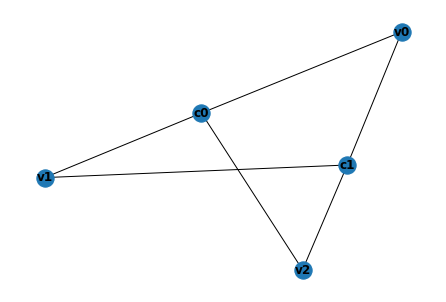

In [4]:
parent_graph = parity_check_mat_to_tanner(np.array([[1,1,1],[1,1,1]]))
nx.draw(parent_graph, with_labels=True, font_weight='bold')
thingie = construct_graph_chain_segment(2)
#thingie.add_edge('v0', 'c10')
#print(thingie.nodes)
#nx.draw(thingie, with_labels=True, font_weight='bold')
pc_mat = tanner_to_parity_check_mat(parent_graph)
print(pc_mat)

18


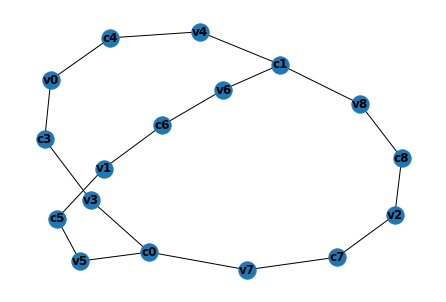

In [5]:
parent_graph = parity_check_mat_to_tanner(np.array([[1,1,1],[1,1,1]]))
#thingie = construct_graph_chain_segment(2)
#print(thingie.nodes)
#thingie_new = relabel_nodes(thingie, parent_graph)
#nx.draw(thingie, with_labels=True, font_weight='bold')
edge_aug_graph = g_augmented_ldpc_code(parent_graph, 1)
print(len(list(edge_aug_graph.edges)))
nx.draw(edge_aug_graph, with_labels=True, font_weight='bold')
#nx.draw(parent_graph, with_labels=True, font_weight='bold')

In [6]:
def prod_code_vars(G: nx.Graph) -> List:
    """ 
    Returns list of variable nodes in product code graph

    Parameters:
    -----------
    G - product code graph
    """
    check_node_list = []
    for tup in list(G.nodes):
        if (tup[0][0] == 'v' and tup[1][0] == 'v') or (tup[0][0] == 'c' and tup[1][0] == 'c'):
            check_node_list.append(tup)
    return check_node_list

def prod_code_checks_X(G: nx.Graph) -> List:
    """ 
    Returns list of check nodes for X checks in product code graph

    Parameters:
    -----------
    G - product code graph
    """
    X_check_var_list = []
    for tup in list(G.nodes):
        if (tup[0][0] == 'c' and tup[1][0] == 'v'):
            X_check_var_list.append(tup)
    return X_check_var_list

def prod_code_checks_Z(G: nx.Graph) -> List:
    """ 
    Returns list of check nodes for Z checks in product code graph

    Parameters:
    -----------
    """
    Z_check_var_list = []
    for tup in list(G.nodes):
        if (tup[0][0] == 'v' and tup[1][0] == 'c'):
            Z_check_var_list.append(tup)
    return Z_check_var_list

def parity_check_mat_X(G: nx.Graph, check_nodes_X: List, var_nodes: List) -> np.array:
    """ 
    Returns the H_X parity-check matrix

    Parameters:
    -----------
    * G - product code graph
    * check_nodes_X - list of check nodes involved in X checks of product code
    * var_nodes - list of variable nodes of Tanner graph of product code 
    """
    num_check_nodes_X = len(check_nodes_X)
    num_var_nodes = len(var_nodes)
    x_mat = np.zeros((num_check_nodes_X, num_var_nodes))
    for i in range(num_check_nodes_X):
        for nbr in nx.neighbors(G, check_nodes_X[i]):
            x_mat[i][var_nodes.index(nbr)] = 1
    return x_mat

def parity_check_mat_Z(G: nx.Graph, check_nodes_Z: List, var_nodes: List) -> np.array:
    """ 
    Returns the H_Z parity-check matrix

    Parameters:
    -----------
    * G - product code graph
    * check_nodes_Z - list of check nodes involved in Z checks of product code
    * var_nodes - list of variable nodes of Tanner graph of product code
    """
    num_check_nodes_Z = len(check_nodes_Z)
    num_var_nodes = len(var_nodes)
    z_mat = np.zeros((num_check_nodes_Z, num_var_nodes))
    for i in range(num_check_nodes_Z):
        for nbr in nx.neighbors(G, check_nodes_Z[i]):
            z_mat[i][var_nodes.index(nbr)] = 1
    return z_mat

def construct_hypergraph_prod_code(pc_mat_1: np.array, pc_mat_2: np.array) -> Tuple:
    """ 
    Constructs hypergraph product code from 2 classical LDPC Code. 

    Parameters:
    -----------
    * pc_mat_1 - 1st parity-check matrix
    * pc_mat_2 - 2nd parity-check matrix

    Returns:
    * (X_pc_mat, Z_pc_mat) - Tuple where 1st element is the X-parity check matrix and 2nd element is the Z-parity check matrix
    """
    tan_graph_1 = parity_check_mat_to_tanner(pc_mat_1)
    tan_graph_2 = parity_check_mat_to_tanner(pc_mat_2)
    prod_code_graph = nx.cartesian_product(tan_graph_1, tan_graph_2)
    var_node_list = prod_code_vars(prod_code_graph)
    X_check_list = prod_code_checks_X(prod_code_graph)
    Z_check_list = prod_code_checks_Z(prod_code_graph)
    X_parity_check_mat = parity_check_mat_X(prod_code_graph, X_check_list, var_node_list)
    Z_parity_check_mat = parity_check_mat_Z(prod_code_graph, Z_check_list, var_node_list)
    return (X_parity_check_mat, Z_parity_check_mat)

The rows of the parity check matrix of C generates C_dual. Therefore, the rows of the parity-check matrix of C_dual generates C. C is the null-space of the parity-check matrix of C. 

1) Find out the null-space of the parity-check matrix of C
2) Fidn the basis of this null-space
3) This defines the rows of C_dual

In [7]:
# Tanner graph for (2,3)-LDPC code
two_three_code_tanner = parity_check_mat_to_tanner(np.array([[1,1,1],[1,1,1]]))

# Parity-check matrix for above tanner graph
two_three_code_pc = matrix(GF(2), tanner_to_parity_check_mat(two_three_code_tanner))
print(np.array(two_three_code_pc, dtype=int))

# Codespace for (2,3)-LDPC code
two_three_code = two_three_code_pc.right_kernel()

# Parity-check matrix for dual of (2,3)-LDPC code
two_three_code_dual_pc = np.array(two_three_code.basis_matrix(), dtype=int)
print(two_three_code_dual_pc)

# Tanner graph for dual of (2,3)-LDPC code
two_three_code_dual_tanner = parity_check_mat_to_tanner(two_three_code_dual_pc)
#nx.draw(two_three_code_dual_tanner, with_labels=True, font_weight='bold')

# Construct semi-topological code with g = 0
g_zero_code = construct_hypergraph_prod_code(np.array(two_three_code_pc, dtype=int), two_three_code_dual_pc)
g_zero_code_x = g_zero_code[0]
print("The X parity-check matrix for this code is: " + "\n" + str(g_zero_code_x))
g_zero_code_z = g_zero_code[1]
print("The Z parity-check matrix for this code is: " + "\n" + str(g_zero_code_z))
print(len(g_zero_code_x[0]))


[[1 1 1]
 [1 1 1]]
[[1 0 1]
 [0 1 1]]
The X parity-check matrix for this code is: 
[[1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0.]
 [1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1.]]
The Z parity-check matrix for this code is: 
[[1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1.]]
13


[[0 0 0 1 0 1 0 1 0]
 [0 0 0 0 1 0 1 0 1]
 [1 0 0 1 0 0 0 0 0]
 [1 0 0 0 1 0 0 0 0]
 [0 1 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 0 1]]
[[1 0 1 1 1 0 0 1 1]
 [0 1 1 0 0 1 1 1 1]]
The X parity-check matrix for this code is: 
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 1. 1.]]
The Z parity-check matrix for this code is: 
[[1. 0. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
97


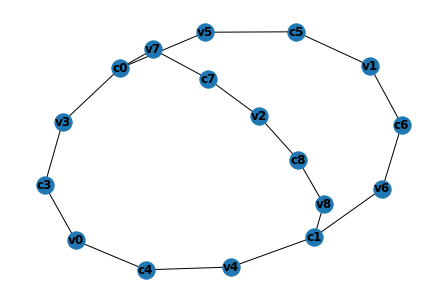

In [8]:
two_three_code_tanner = parity_check_mat_to_tanner(np.array([[1,1,1],[1,1,1]]))

# Construct semi-topological code with g = 1
two_three_aug_1_tanner = g_augmented_ldpc_code(two_three_code_tanner, 1)
nx.draw(two_three_aug_1_tanner, with_labels=True, font_weight='bold')

# Parity-check matrix for above tanner graph
two_three_aug_1_pc = matrix(GF(2), tanner_to_parity_check_mat(two_three_aug_1_tanner))
print(np.array(two_three_aug_1_pc, dtype=int))

# Codespace for above code
two_three_aug_1_code = two_three_aug_1_pc.right_kernel()

# Parity-check matrix for dual of above code
two_three_aug_1_dual_pc = np.array(two_three_aug_1_code.basis_matrix(), dtype=int)
print(two_three_aug_1_dual_pc)

# Tanner graph for dual of above code
two_three_aug_1_dual_tanner = parity_check_mat_to_tanner(two_three_aug_1_dual_pc)

# Construct semi_topological code with g = 1
g_one_code = construct_hypergraph_prod_code(np.array(two_three_aug_1_pc, dtype=int), two_three_aug_1_dual_pc)
g_one_code_x = g_one_code[0]
print("The X parity-check matrix for this code is: " + "\n" + str(g_one_code_x))
g_one_code_z = g_one_code[1]
print("The Z parity-check matrix for this code is: " + "\n" + str(g_one_code_z))
print(len(g_one_code_x[0]))


In [10]:
def belief_prop(H: np.array, s: np.array, p: float, max_iter: int) -> Tuple:
    """ 
    Belief Propagation Algorithm for Decoding LDPC Codes

    Parameters:
    -----------
    H - parity-check matrix corresponding to either X or Z checks
    s - Error syndrome
    p - Channel error rate for chosen noise channel
    max_iter - Maximum number of iterations to run BP algorithm for
    """
    data_to_parity = np.zeros((len(H[0]),len(H)), dtype=float)
    parity_to_data = np.zeros((len(H), len(H[0])), dtype=float)
    H_tanner_graph = parity_check_mat_to_tanner(H)

    # Channel Log Likelihood Ratio
    p_l = np.log((1 - p)/p)
    P_1 = np.zeros((len(H[0]),), dtype=float)
    e_BP = np.zeros((len(H[0]),), dtype=float)

    # (1) Initialization
    for edge in H_tanner_graph.edges:
        data_node_num = int(edge[1][1:])
        parity_node_num = int(edge[0][1:])
        data_to_parity[data_node_num][parity_node_num] = p_l 

    for iter in range(1, max_iter + 1):
        # Scaling Factor
        a = 1 - np.power(2, -1 * iter)

        # (2) Parity to Data Messages
        for edge in H_tanner_graph.edges:
            parity_node_num = int(edge[0][1:])
            data_node_num = int(edge[1][1:])

            # Get list of neighbors of current parity_node set minus the current data node
            V = list(nx.neighbors(H_tanner_graph, edge[0]))
            V.remove(edge[1])

            # Get messages from elements of V to current parity node
            data_to_par_msgs = [data_to_parity[int(v[1:])][parity_node_num] for v in V]
            w = np.min([np.abs(msg) for msg in data_to_par_msgs])
            parity_to_data[parity_node_num][data_node_num] = ((-1) ** s[parity_node_num]) * a * np.prod(np.sign(data_to_par_msgs)) * w 

        # (3) Data to Parity Messages
        for edge in H_tanner_graph.edges:
            data_node_num = int(edge[1][1:])
            parity_node_num = int(edge[0][1:])

            # Get list of neighbors of current data node set minus the current parity node
            U = list(nx.neighbors(H_tanner_graph, edge[1]))
            U.remove(edge[0])

            # Get messages from elements of U to current data node
            par_to_data_msgs = [parity_to_data[int(u[1:])][data_node_num] for u in U]
            data_to_parity[data_node_num][parity_node_num] = p_l + np.sum(par_to_data_msgs)

        # Hard Decision 
        for data_node in [node for node in H_tanner_graph.nodes if node[0] == 'v']:
            data_node_num = int(data_node[1:])

            # Get list of neighbors of current data node 
            U = list(nx.neighbors(H_tanner_graph, data_node))

            # Get messages from elements of U to current data node
            par_to_data_msgs = [parity_to_data[int(u[1:])][data_node_num] for u in U]
            P_1[data_node_num] = p_l + np.sum(par_to_data_msgs)
            e_BP[data_node_num] = -1 * np.sign(P_1[data_node_num])

        # (4) Termination Check
        if (np.equal(np.multiply(H, e_BP), s)):
            return True, e_BP, P_1 

    return False, e_BP, P_1

# Turn to Ordered Statistics Decoding if BP fails to converge
def OSD_0(H: np.array, P_1: np.array, s: np.array) -> np.array:
    """ 
    The Ordered Statistics Decoding (OSD) Zero algorithm is a post-processing 
    algorithm utilized when BP fails to converge 

    Parameters:
    -----------
    H - parity check matrix
    P_1 - BP soft decision vector
    s - Error syndrome 

    Returns:
    --------
    Error string
    """
    S = np.array()

    # Get the rank of the parity check matrix
    H_rank = rank(matrix(H))

    # Maintain a mapping between elements of the BP soft-decision vector and bit positions 
    P_1_dict = {p:i for p in P_1 for i in range(len(P_1))}
    P_1_sorted = np.sort(P_1)
    P_1_sorted_pos = [P_1_dict[p] for p in P_1_sorted]
    
    # Rearrange columns of H to match the reordered soft-decision vector
    idx = np.empty_like(P_1_sorted_pos)
    H[:] = H[:, idx]

    # Select first RANK(H) linearly independent columns of above rearrangement
    _, inds = sympy.Matrix(H).rref()
    H_S = np.vstack((H[:][inds[i]] for i in range(0, H_rank))).T

    # Calculate the OSD-0 solution on the basis-bits
    e_S = np.linalg.inv(H_S) * s
    e_ST = np.hstack((e_S, np.zeros((len(H[0]) - H_rank,))))

    # Map the OSD-0 solution to the original bit-ordering
    e_OSD = np.zeros((len(H[0]),))
    for i in range(len(P_1_sorted_pos)):
        e_OSD[P_1_sorted_pos[i]] = e_ST[i]

    return e_OSD

def OSD_0_Plus(H: np.array, P_1: np.array, s: np.array, e_T: np.array) -> np.array:
    """ 
    The Higher Order OSD algorithm is a post-processing 
    algorithm utilized when BP fails to converge, building 
    on OSD-0 Algorithm

    Parameters:
    -----------
    H - parity check matrix
    P_1 - BP soft decision vector
    s - Error syndrome 
    e_T - Choice of error bits on remaining bits that aren't getting flipped with high enough probability

    Returns:
    --------
    Error string 
    """
    GF = galois.GF(2)
    S = np.array()

    # Get the rank of the parity check matrix
    H_rank = rank(matrix(H))

    # Maintain a mapping between elements of the BP soft-decision vector and bit positions 
    P_1_dict = {p:i for p in P_1 for i in range(len(P_1))}
    P_1_sorted = np.sort(P_1)
    P_1_sorted_pos = [P_1_dict[p] for p in P_1_sorted]
    
    # Rearrange columns of H to match the reordered soft-decision vector
    idx = np.empty_like(P_1_sorted_pos)
    H[:] = H[:, idx]

    # Select first RANK(H) linearly independent columns of above rearrangement
    _, inds = sympy.Matrix(H).rref()
    H_S = np.vstack((H[:][inds[i]] for i in range(0, H_rank))).T
    H_T = np.vstack(H[:][inds[i]] for i in range (H_rank, len(H[0])))

    # Calculate the OSD-0 solution on the basis-bits
    e_S = np.linalg.inv(H_S) * s
    e_ST_1 = GF(np.linalg.inv(H_S) * e_S + np.linalg.inv(H_S) * H_T * e_T)
    e_ST_2 = GF(e_T)
    e_ST = np.hstack((e_ST_1, e_ST_2))

    # Map the OSD-0 solution to the original bit-ordering
    e_OSD = np.zeros((len(H[0]),))
    for i in range(len(P_1_sorted_pos)):
        e_OSD[P_1_sorted_pos[i]] = e_ST[i]

    return e_OSD

In [12]:
def generate_rand_syndrome(s_len: int) -> np.array:
    """ 
    Generate a random syndrome
    """
    s = np.zeros((s_len,))
    for i in range(s_len):
        temp = np.random.randint(0,1)
        s[i] = temp

    return s

# Trying to run BP decoder on toric code
cycle_code = np.array([[1,1,0],[0,1,1],[1,0,1]])
toric_code = construct_hypergraph_prod_code(cycle_code, cycle_code)
toric_code_X = toric_code[0]
toric_code_Z = toric_code[1]

rand_syndrome = generate_rand_syndrome(len(toric_code_X))
max_iter = len(toric_code_X) + len(toric_code_X[0])
converged, hard_BP, soft_BP = belief_prop(toric_code_X, rand_syndrome, 0.5, max_iter)

IndexError: index 9 is out of bounds for axis 0 with size 9